# Word embeddings and logistic regression

These two topics are not inherently related. But we're going to create a connection between them, by using word vectors to create features for a logistic regression model.

To start with, we need to load a slightly larger spaCy model than we used last time.

You may need to change ```python3.7``` to ```python``` or ```python3``` to get this to work.

In [1]:
!python3.7 -m spacy download en_core_web_md

     |████████████████████████████████| 47.1 MB 31.5 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
import spacy, glob
from spacy.lang.en import STOP_WORDS
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import en_core_web_md
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [3]:
engl_nlp = en_core_web_md.load()

In [4]:
test = "I went back to the store, where I found they store their apples in the back."
doc = engl_nlp(test)

In [5]:
doc[0].text

'I'

### Looking at an "embedding"

What actually is it?

In [6]:
print(doc[5].text)
doc[5].vector

store


array([ 4.0443e-01,  2.5853e-02, -2.8242e-01,  1.3591e-01,  5.3162e-01,
        3.5558e-01, -4.4101e-02, -2.6730e-01,  2.4868e-01,  1.6698e+00,
       -3.2510e-01,  1.0311e-01, -5.0500e-03, -4.7872e-01, -1.2018e-01,
        3.1490e-01, -3.2897e-01,  1.8736e+00,  4.9632e-01,  2.2269e-03,
       -4.0535e-01,  2.8639e-01,  9.7010e-04,  4.2422e-02, -2.3239e-01,
        1.4898e-01, -5.9861e-01, -3.1481e-01, -2.4008e-01,  1.3169e-02,
       -3.9922e-01, -1.5233e-01,  3.3129e-01,  1.8193e-01, -5.3594e-01,
        9.4763e-02,  3.1362e-01,  4.1929e-01,  5.5817e-02,  3.9787e-02,
       -3.2780e-01,  1.9989e-01,  5.2690e-01, -2.6164e-01, -3.0180e-01,
        3.0391e-01, -4.4413e-01, -4.0429e-01, -3.8054e-02,  1.5618e-01,
        9.8548e-02,  1.2965e-01,  8.9805e-01,  6.8168e-01,  5.4625e-01,
       -7.8904e-01, -2.1791e-01, -3.7487e-01, -1.2188e-02, -4.4032e-01,
        4.8587e-01, -4.9302e-01, -2.4821e-01,  1.7988e-01,  3.3138e-01,
       -2.6030e-01,  1.7261e-01,  3.1434e-01,  5.4501e-01,  4.93

**SpaCy's embeddings are static rather than contextual.**

One of these stores is a noun, and the other a verb. They shouldn't really be identical, and they won't be when we get to "contextual" embeddings.

In [7]:
print(doc[5].text, doc[11].text)
cosine(doc[5].vector, doc[11].vector)

store store


0.0

### 1. Exploring and visualizing word embeddings

Given a list of words, it's not hard to turn them into a data frame where each row represents an embedding.

In [15]:
vocab = ['apple', 'banana', 'cat', 'dog', 'fish', 'octopus', 'mountain', 'store',
         'river', 'speak', 'run', 'shudder', 'in', 'out', 'love', 'hate']

In [16]:
vectordict = dict()
for v in vocab:
    doc = engl_nlp(v)
    vectordict[v] = doc[0].vector

In [17]:
vectordf = pd.DataFrame.from_dict(vectordict, orient = 'index')
vectordf

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
apple,-0.363910,0.437710,-0.204470,-0.228890,-0.142270,0.273960,-0.011435,-0.185780,0.373610,0.753390,...,-0.677310,0.280900,-0.517700,-0.410980,-0.412920,-0.067856,-0.033721,-0.729580,-0.478910,0.729560
banana,0.202280,-0.076618,0.370320,0.032845,-0.419570,0.072069,-0.374760,0.057460,-0.012401,0.529490,...,0.170570,0.366850,0.002525,-0.640090,-0.297650,0.789430,0.331680,-1.196600,-0.047156,0.531750
cat,-0.150670,-0.024468,-0.233680,-0.233780,-0.183820,0.327110,-0.220840,-0.287770,0.127590,1.165600,...,-0.331810,-0.109020,-0.023324,0.210600,-0.296330,0.815060,0.038524,0.460040,0.171870,-0.298040
dog,-0.401760,0.370570,0.021281,-0.341250,0.049538,0.294400,-0.173760,-0.279820,0.067622,2.169300,...,0.022908,-0.259290,-0.308620,0.001754,-0.189620,0.547890,0.311940,0.246930,0.299290,-0.074861
fish,-0.396710,-0.372360,-0.055794,0.071283,0.082012,0.672970,-0.551350,0.093016,-0.090448,1.742100,...,-0.231210,-0.389390,-0.776320,-0.238190,-0.101480,0.524810,-0.434280,-0.493160,0.228060,-0.464670
octopus,-0.091032,-0.789440,0.335180,0.269630,-0.332700,-0.028616,-0.546650,0.108790,0.071888,0.041089,...,0.049008,-0.099616,-0.501780,0.202700,0.034787,0.248630,-0.121850,-0.031629,0.579100,-0.076863
mountain,0.464630,0.102960,-0.171300,-0.718780,0.269900,0.606360,0.071690,0.710450,-0.627470,2.118600,...,-0.284770,0.207710,-0.039287,-0.065834,-0.464540,-0.055423,0.808050,0.639210,0.089043,-0.294910
store,0.404430,0.025853,-0.282420,0.135910,0.531620,0.355580,-0.044101,-0.267300,0.248680,1.669800,...,-0.695500,0.109830,0.274740,0.471180,-0.268330,-0.658020,0.036198,-0.399580,-0.184300,0.544480
river,0.096865,-0.290630,-0.220770,-0.780660,0.451750,0.923940,-0.565470,0.310980,-0.520390,2.432300,...,-0.333290,-0.192210,-0.600980,-0.392950,-0.067076,0.021785,-0.323220,-0.203230,-0.395790,-0.601690
speak,-0.210720,0.194310,-0.321450,0.499840,0.611310,-0.234940,0.156100,-0.267960,-0.383230,3.139700,...,0.176900,-0.275470,-0.346260,-0.029795,0.102970,0.268720,0.028883,0.171640,0.260060,0.173730


#### We can measure the cosine between vectors to get a kind of "distance" between embeddings

compare the two pairs below.

In [14]:
cosine(vectordf.loc['octopus', : ], vectordf.loc['in', : ])

0.9517824345982444

In [11]:
cosine(vectordf.loc['cat', : ], vectordf.loc['dog', : ])

0.1983144944405293

#### Using principal component analysis to visualize a semantic space

Whenever we have a high-dimensional matrix like the one above, it's possible to use dimension-reduction techniques to flatten it into a plane (with some loss of information).

In [18]:
def vocab2pca(vocab):
    
    vectordict = dict()        # create a df of embeddings
    for v in vocab:
        doc = engl_nlp(v)
        vectordict[v] = doc[0].vector
        
    vectordf = pd.DataFrame.from_dict(vectordict, orient = 'index')
    
    vectorlengths = np.linalg.norm(vectordf, ord = 2, axis = 1)   # normalize vector lengths
    vectordf = vectordf.divide(vectorlengths, axis = 'rows')      # for PCA
    
    pca = PCA(n_components = 2)       
    components = pca.fit_transform(vectordf)                      # perform PCA
    plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1]}, index = vocab)
    
    return plotframe

In [19]:
plotframe = vocab2pca(vocab)
plotframe

,x,y
apple,0.280737,0.120833
banana,0.392120,0.250536
cat,0.291609,0.085218
dog,0.186828,-0.016832
fish,0.449164,-0.086433
octopus,0.558947,0.267313
mountain,0.079412,-0.393369
store,-0.028973,-0.254545
river,0.140513,-0.471709
speak,-0.476229,0.145616


In [20]:
def plot_the_frame(plotframe):    
    plt.figure(figsize = (10, 8))
    theplot = sns.scatterplot(x = plotframe.iloc[ : , 0], y = plotframe.iloc[ : , 1])
    collabels = plotframe.columns.tolist()
    theplot.set(xlabel = collabels[0], ylabel = collabels[1])

    for rownum in range(plotframe.shape[0]):
        x = plotframe.iloc[rownum, 0]
        y = plotframe.iloc[rownum, 1]
        theplot.text(x + 0.007, y + .007, 
        plotframe.index[rownum], horizontalalignment='left', 
        size='medium', color='black', weight='semibold')

    plt.show()

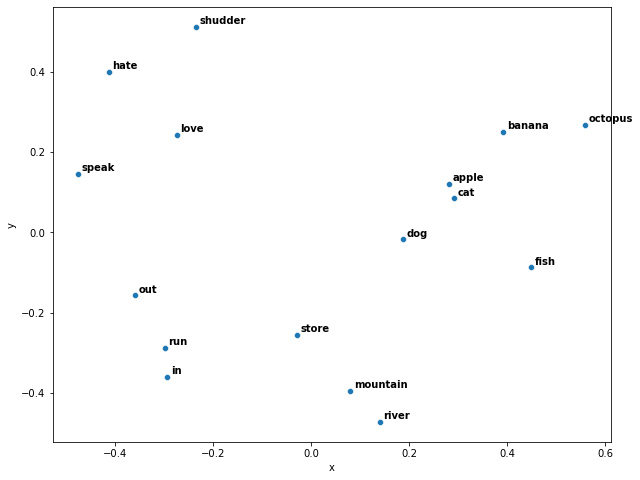

In [21]:
plot_the_frame(plotframe)

#### That was fun. Let's zoom in on the animals over on the noun side of things.

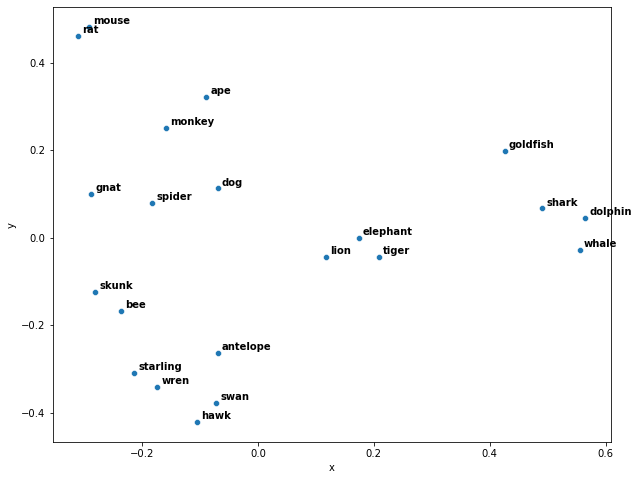

In [22]:
animals = ['starling', 'swan', 'hawk', 'dolphin', 'shark', 'whale', 'goldfish', 'lion', 'elephant', 
           'antelope', 'skunk', 'mouse', 'spider', 'gnat', 'ape', 'dog', 'rat', 'bee', 'tiger',
          'wren', 'monkey']
plotframe = vocab2pca(animals)
plot_the_frame(plotframe)

**Can we interpret this?**

There are certainly groups of animals visible here. How would you describe them?

But it's rarely easy to say what the *x* and *y* axes represent in a PCA plot.

However, we can create axes that are a little more interpretable if we like.

In [23]:
def get_vectors(wordlist): 
    vectors = []
    
    for ex in wordlist:        # for each word in a wordlist
        doc = engl_nlp(ex)
        vec = doc[0].vector    # get its vector
        vectorlength = np.linalg.norm(vec, ord = 2)     # normalize length
        vectors.append(vec / vectorlength)              # and save it in a list
        
    thesum = np.sum(vectors, axis = 0)                  # then add all the vectors
    vectorlength = np.linalg.norm(thesum, ord = 2)      # normalize length again
    
    return thesum / vectorlength

def make_direction(positive_examples, negative_examples):
    
    posvector = get_vectors(positive_examples)           # create a mean positive vector
    negvector = get_vectors(negative_examples)           # and negative vector
    direction = posvector - negvector                    # subtract the second from the first
    
    return direction
    

In [24]:
airvswater = make_direction(['fly', 'wings', 'air'], ['swim', 'fins', 'water'])
bigvslittle = make_direction(['big', 'huge', 'large'], ['small', 'tiny'])

Now, how do we use these two "directions" to organize a space?

We'll give each word an x position that is its cosine similarity to the first direction, and a y position that is its cosine similarity to the second.

In [25]:
def organizeby2dims(words, ref_vector1, ref_vector2, col1name, col2name):
    dict4df = dict()
    
    for colname in [col1name, col2name]:       # create a dictionary with 
        dict4df[colname] = []                  # appropriate key names
        
    for w in words:                            # for each word       
        doc = engl_nlp(w)
        vec = doc[0].vector
        cos1 = cosine(vec, ref_vector1)        # get its x position
        cos2 = cosine(vec, ref_vector2)        # and y position
        
        dict4df[col1name].append(cos1)
        dict4df[col2name].append(cos2)

    plotframe = pd.DataFrame(dict4df, index = words)  # make this a data frame,
                                                      # with words as index labels
    
    return plotframe

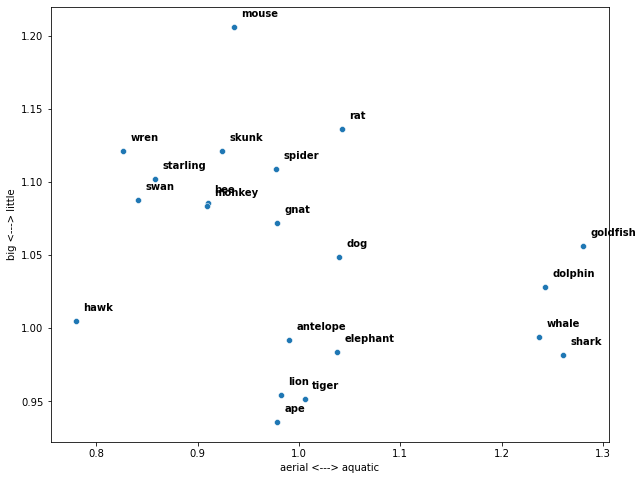

In [26]:
plotframe = organizeby2dims(animals, airvswater, bigvslittle, 'aerial <---> aquatic', 'big <---> little')
plot_the_frame(plotframe)

### 2. Explore an example on your own

Animals (other than hominids) aren't too controversial. Let's consider an example where all kinds of questions about social bias will immediately become obvious.

Here's a list of occupations. Try organizing them along axes like

1. wealthy vs needy
2. famous vs obscure
3. man vs woman
4. You can also fuse 1 & 2: rich and famous vs poor and obscure

Sometimes it helps to invent multiple synonyms for an idea to make sure you get the core idea you're shooting for. (E.g., by itself "rich" could mean, "and creamy, as in a dessert.") So when you make_direction() you might also want to say "wealthy" and "affluent" to make sure you produce a vector that is in the direction you want.

In [28]:
occupations = ['farmer', 'surgeon', 'policeman', 'lawyer', 'actor', 'nurse', 
         'thief', 'politician', 'accountant', 'engineer', 'chef', 'teacher',
              'banker', 'dancer', 'bodyguard', 'pilot', 'actress', 'soldier', 
               'writer', 'artist', 'handyman', 'broker', 'queen']

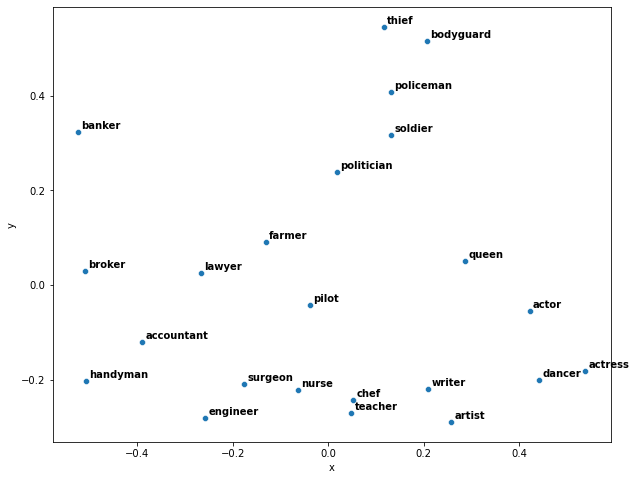

In [29]:
plotframe = vocab2pca(occupations)
plot_the_frame(plotframe)


In [32]:
richandfamous = make_direction(['rich', 'wealthy', 'prominent', 'famous'], ['poor', 'humble', 'obscure'])
masculinefeminine = make_direction(['woman', 'girl', 'feminine'], ['man', 'boy', 'masculine'])

In [ ]:
plotframe = organizeby2dims(occupations, richandfamous, masculinefeminine, 'famous <---> obscure', 'feminine <---> masculine')
plot_the_frame(plotframe)

### You can ignore the section below

I'm just noodling around here, demonstrating that "cosine distance" is not bounded at 1, and finding pairs of words that are exceptionally remote from each other.

In [35]:
abunchofwords = occupations
abunchofwords.extend(animals)
abunchofwords.extend(vocab)

remote = []

for word1 in abunchofwords:
    
    farthestpair = ('null', 'set')
    maxdist = 0
    
    doc = engl_nlp(word1)
    firstvec = doc[0].vector
    
    for word2 in abunchofwords:
        doc = engl_nlp(word2)
        secondvec = doc[0].vector
        
        distance = cosine(firstvec, secondvec)
        if distance > maxdist:
            maxdist = distance
            farthestpair = (word1, word2)
    
    if maxdist > 1:
        remote.append((maxdist, farthestpair))
        
    if len(remote) > 10:
        break

print(remote)
        

[(1.0300366915762424, ('banker', 'actress')), (1.0038220547139645, ('dancer', 'banker')), (1.0071706725284457, ('bodyguard', 'store')), (1.032026831060648, ('actress', 'handyman')), (1.032026831060648, ('handyman', 'actress')), (1.0113505348563194, ('broker', 'ape')), (1.0013482795329764, ('hawk', 'in')), (1.0034760788548738, ('mouse', 'actress')), (1.0113505348563194, ('ape', 'broker')), (1.0005821880185977, ('wren', 'broker')), (1.0071706725284457, ('store', 'bodyguard'))]
